In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

### Precipitation Analysis

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
last_dates = session.query(Measurement.date).order_by(Measurement.date.desc()).first()

last_dates


('2017-08-23')

In [11]:
# Calculate the date 1 year ago from the last data point in the database
one_yr_ago = dt.date(2017,8,23) - dt.timedelta(days=365)

one_yr_ago

datetime.date(2016, 8, 23)

In [12]:
# Perform a query to retrieve the data and precipitation scores
# The data is sorted here with Order_by but I've added an additional sort down below, per instructions
precipitation_data = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= one_yr_ago).\
    order_by(Measurement.date).all()
#precipitation_data

In [13]:
# Save the query results as a Pandas DataFrame and set the index to the date column
precipitation_df = pd.DataFrame(precipitation_data, columns=['date', 'precipitation'])
precipitation_df.head()

,date,precipitation
0,2016-08-23,0.00
1,2016-08-23,0.15
2,2016-08-23,0.05
3,2016-08-23,NaN
4,2016-08-23,0.02


In [14]:
# Sort the dataframe by date
precipitation_df = precipitation_df.sort_values(by='date', ascending=True)
precipitation_df.head()


,date,precipitation
0,2016-08-23,0.00
1,2016-08-23,0.15
2,2016-08-23,0.05
3,2016-08-23,NaN
4,2016-08-23,0.02


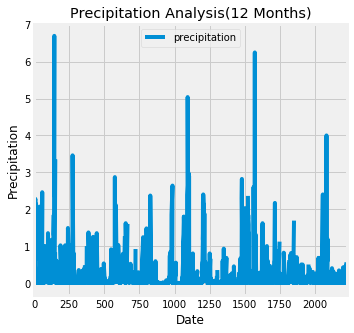

In [15]:
# Use Pandas Plotting with Matplotlib to plot the data
precipitation_df.plot(title='Precipitation Analysis(12 Months)', figsize=(5,5))

# Legend
plt.legend(loc='upper center')
# Labels for x & y axis
plt.xlabel("Date")
plt.ylabel("Precipitation")

# Save Figure & Show
plt.savefig("Images/Precipitation.png", bbox_inches="tight", transparent=True)
plt.show()

In [16]:
# Use Pandas to calculate the summary statistics for the precipitation data
precipitation_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


### Station Analysis

In [17]:
# Design a query to show how many stations are available in this dataset?
stations_available = session.query(Measurement.station).distinct().count()
print(f"Number of Available Stations in Dataset: {stations_available} ")

Number of Available Stations in Dataset: 9 


In [18]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_stations = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).\
        order_by(func.count(Measurement.station).desc()).all()
print(f"List of Most Active Stations")
active_stations

List of Most Active Stations


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [19]:
# Set Most active station
most_active_station = active_stations[0][0]
print(f"Most Active Station: {most_active_station}")

Most Active Station: USC00519281


In [20]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
temp_stats = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), 
                           func.avg(Measurement.tobs)).filter(Measurement.station == most_active_station).all()

print(f"Temperature Stats for Most Active Station: {most_active_station}")
print(f"Lowest Temperature: {temp_stats[0][0]} Highest Temperature: {temp_stats[0][1]} Average Temperature: {round(temp_stats[0][2], 1)}")

Temperature Stats for Most Active Station: USC00519281
Lowest Temperature: 54.0 Highest Temperature: 85.0 Average Temperature: 71.7


In [21]:
# Choose the station with the highest number of temperature observations.
highest_temp_obs = session.query(Measurement.station, func.count(Measurement.tobs)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).first()
highest_temp_obs = highest_temp_obs[0]
highest_temp_obs

'USC00519281'

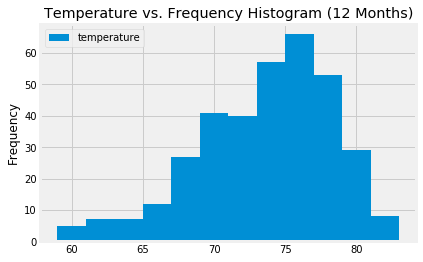

In [22]:
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_obs = session.query(Measurement.tobs).filter(Measurement.date >= one_yr_ago).filter(Measurement.station == highest_temp_obs).all()
temp_obs = pd.DataFrame(temp_obs, columns=['temperature'])

temp_obs.plot.hist(bins=12, title='Temperature vs. Frequency Histogram (12 Months)')

# Save Figure & Show
plt.savefig("Images/tempvsfrequency.png", bbox_inches="tight", transparent=True)
plt.show()

In [23]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [24]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_calc = calc_temps("2017-06-01", "2017-06-14-01")
trip_calc

[(72.0, 77.44444444444444, 83.0)]

In [31]:
trip_calc_df = pd.DataFrame(trip_calc, columns=["tmin", "tavg", "tmax"])
trip_calc_df

,tmin,tavg,tmax
0,72.0,77.444444,83.0


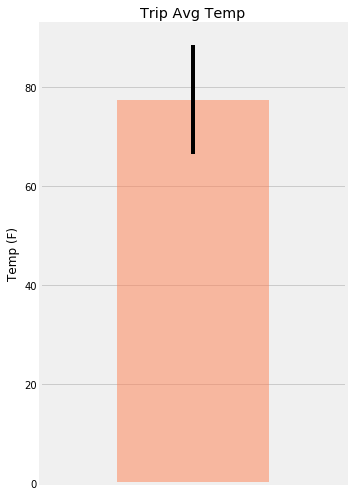

In [54]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
trip_calc_df.plot.bar(y="tavg", yerr=(trip_calc_df["tmax"] - trip_calc_df["tmin"]), color='coral', alpha=0.5, figsize=(5,7), 
                      title='Trip Avg Temp', legend=None)


plt.ylabel("Temp (F)")
plt.xticks([])
plt.tight_layout()

# Save Figure & Show
plt.savefig("Images/tripAVGtemp.png", bbox_inches="tight", transparent=True)
plt.show()

In [26]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



## Optional Challenge Assignment

In [27]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [28]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [29]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [30]:
# Plot the daily normals as an area plot with `stacked=False`
